In [2]:
import pandas as pd
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time
import warnings

In [3]:
start = time.time()
data = pd.read_excel('data.xlsx',skiprows=2)
end = time.time()
print(f'data recorded, time elapsed: {end-start}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


data recorded, time elapsed: 435.6204662322998


In [4]:
data = data[(data['Тип субъекта'] == 'Юридическое лицо') & (data['Категория'].isin(['Малое предприятие', 'Среднее предприятие']))]
data = data[data['Основной вид деятельности'] == '41.20 Строительство жилых и нежилых зданий']
data = data.reset_index()
del data['index']

In [5]:
data.head(3)

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,20,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",Юридическое лицо,Малое предприятие,1025004907080,5038038838,41.20 Строительство жилых и нежилых зданий,50 - Московская область,Пушкино г,NaN,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,36.0
1,52,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",Юридическое лицо,Среднее предприятие,1025007270551,5027006369,41.20 Строительство жилых и нежилых зданий,50 - Московская область,NaN,г Дзержинский,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,201.0
2,4653,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",Юридическое лицо,Малое предприятие,1021400692048,1414006922,41.20 Строительство жилых и нежилых зданий,77 - г.Москва,NaN,NaN,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,35.0


EBITDA = прибыль до налогообложения + расходы по процентам + расходы на амортизацию основных средств и нематериальных активов. Посчитаем данный показатель.

In [6]:
ebtd = pd.DataFrame(
    columns=['ИНН','2023', '2022','2021','2020','2019']
)
net_income = pd.DataFrame(
    columns=['ИНН','2023', '2022','2021','2020','2019']
)
rev = pd.DataFrame(columns = ['ИНН','revenue for 2023'])

Спарсим данные с сайта налоговой:

In [10]:
headers = {
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36', 
}

ebitda_data = {
    'ИНН' : None,
    '2023': None,
    '2022': None,
    '2021': None,
    '2020': None,
    '2019': None
}
net_income_data = {
    'ИНН' : None,
    '2023': None,
    '2022': None,
    '2021': None,
    '2020': None,
    '2019': None
}
rev_data = {
    'ИНН' : None,
    'revenue for 2023': None
}
session = requests.Session()
count = 0
time_start = time.time()
for inn in data['ИНН']:
    ebitda_data['ИНН'] = inn
    net_income_data['ИНН'] = inn
    rev_data['ИНН'] = inn
    if count % 500 == 0:
        time_prom = time.time()
        print(f'current company index {count}, time elapsed in mins: {round((time_prom-time_start)/60,2)}')
    #вытаскиваем id по инн компании
    if inn == 7825012056 or inn == 9701016076:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)  # сайт вообще виснет при поиске данных компании ( проверил вручную)
            ebtd.loc[count] = {'ИНН' : inn,'2023':None,'2022':None,'2021':None,'2020':None,'2019':None}
            net_income.loc[count] = {'ИНН' : inn,'2023':None,'2022':None,'2021':None,'2020':None,'2019':None}
            rev.loc[count] = {'ИНН': inn, 'revenue for 2023': None} 
        continue
    
    url = f"https://bo.nalog.ru/advanced-search/organizations/search?query={inn}&page=0"

    response = session.get(url, headers=headers)
    if len(response.json()['content']) != 0:
        id = response.json()['content'][0]['id']
        #по id ищем отчетность
        url1 = f'https://bo.nalog.ru/nbo/organizations/{id}/bfo/' 
        res = session.get(url1, headers=headers).json()
        # получили отчетность, итерируемся по годам и считаем EBITDA
        for i in range(len(res)):
            year = res[i]['period']
            if 'financialResult' in res[i]['correction'].keys():
                finrez = res[i]['correction']['financialResult']
                if 'current2300' in finrez.keys() and 'current2330' in finrez.keys():
                    ebitda = finrez['current2300'] + finrez['current2330'] #прибыль до налогов + проценты  
                    ebitda_data[year] = ebitda
                if (year == '2023') and ('current2110' in finrez.keys()):
                    rev_data['revenue for 2023'] = finrez['current2110']
                if 'current2400' in finrez.keys():
                    net_income_data[year] = finrez['current2400']
            
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        ebtd.loc[count] = ebitda_data
        net_income.loc[count] = net_income_data
        rev.loc[count] = rev_data

    ebitda_data = {
    'ИНН' : None,
    '2023': None,
    '2022': None,
    '2021': None,
    '2020': None,
    '2019': None
    }
    net_income_data = {
    'ИНН' : None,
    '2023': None,
    '2022': None,
    '2021': None,
    '2020': None,
    '2019': None
}
    rev_data = {
    'ИНН' : None,
    'revenue for 2023': None
}
    count += 1

current company index 0, time elapsed in mins: 0.0
current company index 500, time elapsed in mins: 0.87
current company index 1000, time elapsed in mins: 1.75
current company index 1500, time elapsed in mins: 2.63
current company index 2000, time elapsed in mins: 3.52
current company index 2500, time elapsed in mins: 4.37
current company index 3000, time elapsed in mins: 5.24
current company index 3500, time elapsed in mins: 6.15
current company index 4000, time elapsed in mins: 7.03
current company index 4500, time elapsed in mins: 7.99
current company index 5000, time elapsed in mins: 8.89
current company index 5500, time elapsed in mins: 9.87
current company index 6000, time elapsed in mins: 10.8
current company index 6500, time elapsed in mins: 11.71
current company index 7000, time elapsed in mins: 12.65
current company index 7500, time elapsed in mins: 13.61
current company index 8000, time elapsed in mins: 14.58
current company index 8500, time elapsed in mins: 15.57


In [68]:
net_income

,ИНН,2023,2022,2021,2020,2019


In [54]:
nice_data = pd.merge(data, ebtd, on=['ИНН'])
nice_data = nice_data.replace([np.nan],['unknown'])

In [55]:
nice_data = nice_data[(nice_data['2023']!='unknown')]
nice_data = nice_data[(nice_data['2022']!='unknown')]
nice_data = nice_data[(nice_data['2021']!='unknown')]
nice_data = nice_data[(nice_data['2020']!='unknown')]
nice_data.head(3)

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год,2023,2022,2021,2020,2019
0,20,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",Юридическое лицо,Малое предприятие,1025004907080,5038038838,41.20 Строительство жилых и нежилых зданий,50 - Московская область,Пушкино г,unknown,...,Нет,Нет,Нет,Нет,36.0,-17331.0,20360.0,9031.0,14627.0,unknown
5,4677,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКЦИОНЕРНАЯ ПРОИЗВОДСТВЕ...",Юридическое лицо,Малое предприятие,1023500875870,3525048992,41.20 Строительство жилых и нежилых зданий,35 - Вологодская область,unknown,г Вологда,...,Нет,Нет,Нет,Нет,14.0,243530.0,14755.0,16672.0,-14866.0,unknown
7,4693,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АМБЕР-СТРОЙСЕРВИС""",Юридическое лицо,Малое предприятие,1025900534406,5902126804,41.20 Строительство жилых и нежилых зданий,59 - Пермский край,unknown,г Пермь,...,Нет,Нет,Нет,Нет,30.0,2132.0,5436.0,11054.0,-12937.0,unknown


Text(0.5, 1.0, 'EBITDA отрасли строительства в зависимости от года')

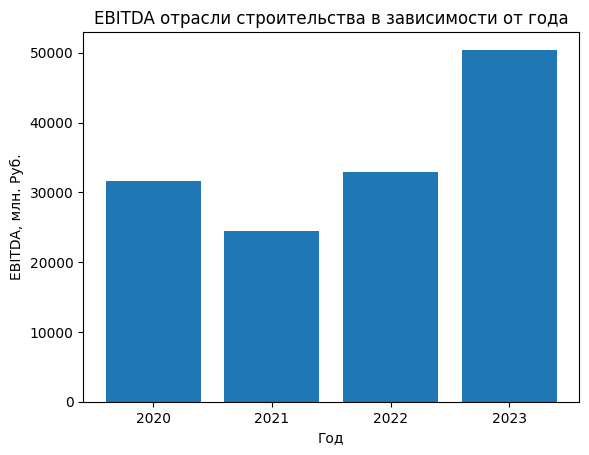

In [58]:
# посчитаем EBITDA всей отрасли по годам:
ebitda_constr = []
years = ['2020','2021','2022','2023']
for year in years:
    sum_ebd = nice_data[year].sum()
    ebitda_constr.append(sum_ebd / 1000)
plt.bar(years,ebitda_constr)

plt.xlabel('Год')
plt.ylabel('EBITDA, млн. Руб.')
plt.title('EBITDA отрасли строительства в зависимости от года')


Итого - отрасль строительсва, исходя из анализа суммарной EBITDA компаний по годам, перспективна, так как EBITDA отрасли растет последние несколько лет. Просадка в 21 году обусловлена последствиями пандемии, однако уже 22 году рынок восстановился и рост продолжился.

далее графики роста чистой прибыли

In [69]:
net_income = net_income.replace([np.nan],['unknown'])
net_income = net_income[(net_income['2023']!='unknown')&
                            (net_income['2022']!='unknown')&
                            (net_income['2021']!='unknown')&
                            (net_income['2020']!='unknown')
] 

Теперь посчитаем изменения чистой прибыли 23 года относительно предыдущих

In [60]:
net23 = net_income['2023'].to_list()
net22 = net_income['2022'].to_list()
net21 = net_income['2021'].to_list()
net20 = net_income['2020'].to_list()
net19 = net_income['2019'].to_list()

def net_change(a=[],b=[]):
    c = []
    for i in range(len(a)):
        if (a[i] > 0 and b[i] > 0) or (a[i] < 0 and b[i] > 0):
            c.append(round((a[i] / b[i] -1)*100,0))
        elif(a[i] > 0 and b[i] < 0) or (a[i] < 0 and b[i] < 0):
            c.append(round((a[i] / abs(b[i]) + 1)*100,0))
        elif a[i] == 0 and b[i] == 0:
            c.append(0)
        elif a[i] == 0 and b[i] != 0:
            if b[i] > 0:
                c.append(-100)
            else:
                c.append(100)
        elif a[i] != 0 and b[i] == 0:
            continue
    return c

In [61]:
def func_to_get_coord(l = []):
    dict = {}
    for i in range(len(l)):
        if l[i] in dict.keys():
            dict[l[i]] += 1
        else:
            dict[l[i]] = 1
    list = sorted(dict.items())
    cord = [[],[]]
    for i in range(len(list)):
        cord[0].append(list[i][0])
        cord[1].append(list[i][1])
    return cord

In [62]:

coords_N_1 = func_to_get_coord(net_change(net23,net22))
coords_N_2 = func_to_get_coord(net_change(net23,net21))
coords_N_3 = func_to_get_coord(net_change(net23,net20))
coords_N_4 = func_to_get_coord(net_change(net23,net19))

Text(0.5, 1.0, 'Изменение прибыли компании в 23 году относительно 21 года - кол-во компаний с таким % \n Данные в промежутке изменения -400%, 400%')

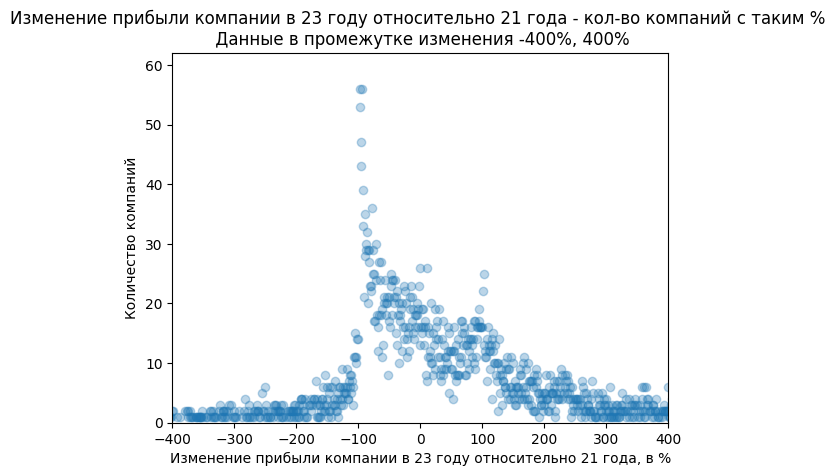

In [ ]:
plt.scatter(coords_N_2[0],coords_N_2[1],alpha = 0.3)
plt.xlim(-400,400) 
plt.ylim(0,62)
plt.xlabel('Изменение прибыли компании в 23 году относительно 21 года, в %')
plt.ylabel('Количество компаний')
plt.title('Изменение прибыли компании в 23 году относительно 21 года - кол-во компаний с таким % \n Данные в промежутке изменения -400%, 400%')

Text(0.5, 1.0, 'Изменение прибыли компании в 23 году относительно 20 года - кол-во компаний с таким % \n Данные в промежутке изменения -400%, 400%')

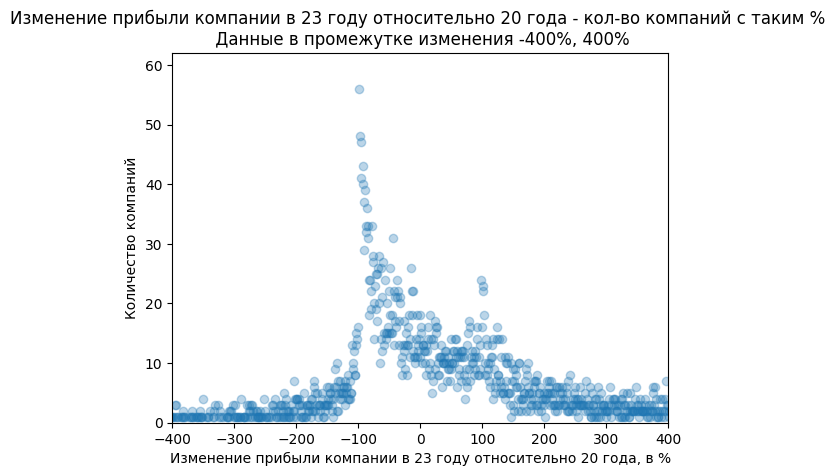

In [ ]:
plt.scatter(coords_N_3[0],coords_N_3[1],alpha = 0.3)
plt.xlim(-400,400) 
plt.ylim(0,62)
plt.xlabel('Изменение прибыли компании в 23 году относительно 20 года, в %')
plt.ylabel('Количество компаний')
plt.title('Изменение прибыли компании в 23 году относительно 20 года - кол-во компаний с таким % \n Данные в промежутке изменения -400%, 400%')

Text(0.5, 1.0, 'Изменение прибыли компании в 23 году относительно 20 года - кол-во компаний с таким % \n Данные в промежутке изменения -400%, 400%')

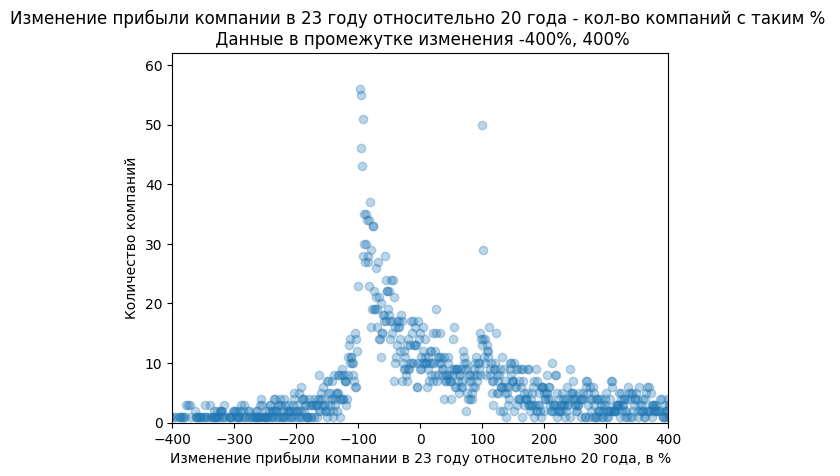

In [ ]:
plt.scatter(coords_N_4[0],coords_N_4[1],alpha = 0.3)
plt.xlim(-400,400) 
plt.ylim(0,62)


Text(0.5, 1.0, 'относительно 19 года')

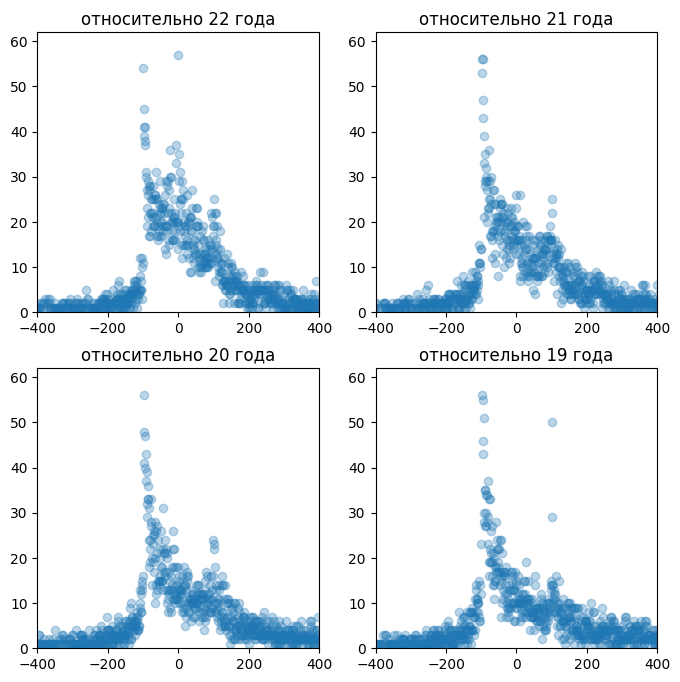

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.scatter(coords_N_1[0],coords_N_1[1],alpha = 0.3)
plt.xlim(-400,400) 
plt.ylim(0,62)
plt.title('относительно 22 года')

plt.subplot(2, 2, 2)
plt.scatter(coords_N_2[0],coords_N_2[1],alpha = 0.3)
plt.xlim(-400,400) 
plt.ylim(0,62)
plt.title('относительно 21 года')


plt.subplot(2, 2, 3)
plt.scatter(coords_N_3[0],coords_N_3[1],alpha = 0.3)
plt.xlim(-400,400) 
plt.ylim(0,62)
plt.title('относительно 20 года')


plt.subplot(2, 2, 4)
plt.scatter(coords_N_4[0],coords_N_4[1],alpha = 0.3)
plt.xlim(-400,400) 
plt.ylim(0,62)
plt.title('относительно 19 года')


Выводы: 
1) Изменение чистой прибыли более чем на 200% год к году - нечастое среди компаний явление.
2) на всех графиках в промежутке -100%:100% очевидна зависимость: с уменьшением процента изменения чистой прибыли увеличивается число компаний. Сделаем вывод, что в 2024 году чистая прибыль относительно прошлых лет уменьшалась у бОльшей части компаний выборки.

(0.0, 4300.0)

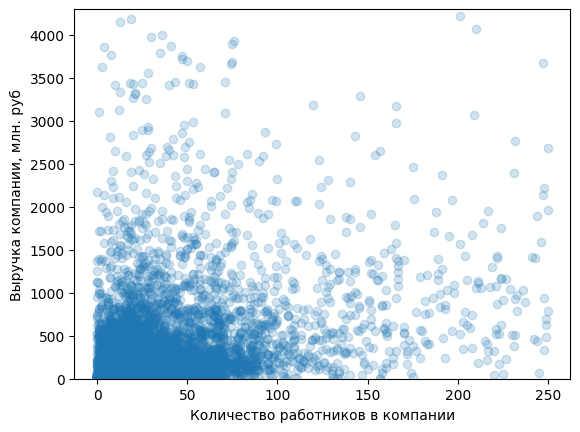

In [76]:
data_pl = pd.merge(data, rev, on=['ИНН'])
data_pl = data_pl.sort_values(by='revenue for 2023',ascending=False)
plt.scatter(data_pl['Среднесписочная численность работников за предшествующий календарный год'],data_pl['revenue for 2023'] / 1000,alpha = 0.2)
plt.xlabel('Количество работников в компании')
plt.ylabel('Выручка компании, млн. руб')
plt.ylim(0,4300)

Выше график кол-во работников - выручка. Я получил немного не то что ожидал - казалось бы, чем больше выручка, тем больше должно работать человек в компании. Смотря на график, понимаем, что гипотеза не потвердилась ;)). Вывод: выручка не зависит от количетсва работников.

Далее проанализируем топ 500 компаний по выручке

In [114]:
data_pl = data_pl.replace(np.nan,'nothing')
data_pl = data_pl[data_pl['Город'] != 'nothing']
top_500rev = data_pl[:500].copy()
top_500rev['Город']

5508      Волгоград
7247      Ярославль
3742    Новосибирск
3102    Красногорск
5291          Пермь
           ...     
1197         Самара
5381          Кызыл
3182            Уфа
5554       Кизилюрт
8401          г Уфа
Name: Город, Length: 500, dtype: object

In [115]:
# убираем 'г' в ячейке города
top_500rev['Город'] = top_500rev['Город'].apply(lambda st: st.split()[1] if st[0] == 'г' else st)


на просторах инета нашел табличку с координаами городов

In [116]:
df = pd.read_excel('spisok_gorodov_RU.xlsx')
del df['Регион']
del df['Округ']

In [117]:
dataframe = pd.merge(top_500rev,df,on='Город')
dataframe = dataframe.sort_values(by='revenue for 2023', ascending=False)
dataframe = dataframe.reset_index()
del dataframe['index']
dataframe = dataframe.reset_index()
del dataframe['Район']
del dataframe['ОГРН']

возникла проблема - я отмечаю на карте города, в которых зарегестрированы компании. Получается, что если в одном городе больше однйо компании, они друг друга перекрывают и видно только одну. Поскольку для исправления по честному нужны точные широта/долгота компании, которые негде спарсить, я сделаю небольшой костыль: у каждой компании подвину  немного коордианты города, в таком случае наложений не будет 

In [118]:
import random

In [119]:
for i in range(472):
    lon = dataframe['Долгота'].iloc[i]
    lat = dataframe['Широта'].iloc[i]
    correction = random.uniform(0.01, 0.05)
    rnd = random.randint(0,2)

    if rnd == 0:
        lon -= correction
        lat += correction
    elif rnd == 1:
        lon += correction
        lat += correction
    else:
        lon -= correction
        lat -= correction


    dataframe.loc[dataframe['index'] == i, 'Долгота'] = lon
    dataframe.loc[dataframe['index'] == i, 'Широта'] = lat

In [120]:

fig = px.scatter_mapbox(dataframe, lat="Широта", lon="Долгота", hover_name="Наименование / ФИО", hover_data=["Город",'ИНН','index','revenue for 2023'],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=500)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Получили довольно очевидную зависимость: большинство компаний страны, входящих в топ 500 по выручке, находятся в западной части РФ